<center>

## MAGICIAN: Mining and gAmblinG servIces sCrapIng and ANalysis

Matteo Martini 636694

In [2]:
mining_pool_url = "https://en.bitcoin.it/wiki/DeepBit9"
full_wallet_address = "https://www.walletexplorer.com/wallet/"


#Individuare nel DataSet tutte le transazioni relative a Deepbit.net,ovvero le transazioni che presentano almeno un indirizzo di input o di output appartenente a Deepbit_addrs.
#servizio scommesse = DiceOnCrack

## Setup Ambiente

In [3]:
# Librerie concesse
import pandas as pd

# Per scraping (scegline uno o entrambi, in base alle esigenze delle pagine)
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options

# Per formati efficienti (PyArrow)
import pyarrow as pa
import pyarrow.parquet as pq

# Utility
from pathlib import Path
from datetime import datetime

import numpy as np


from selenium.webdriver.support.select import Select
from selenium.webdriver.common.keys import Keys
import time
import requests
import re
from bs4 import BeautifulSoup

# Percorsi (aggiorna con il tuo percorso locale)
DATA_DIR = Path('./Datasets')   # metti qui i CSV scaricati

PARQUET_DIR = Path('./data_parquet')
PARQUET_DIR.mkdir(parents=True, exist_ok=True)
print('Environment ready.')

Environment ready.


## 1) Costruzione dei Dataframe dal Dataset

## Directory Datasets


In [4]:
transactions_csv = DATA_DIR / 'transactions.csv'
inputs_csv       = DATA_DIR / 'inputs.csv'
outputs_csv      = DATA_DIR / 'outputs.csv'
mapping_csv      = DATA_DIR / 'mapAddr2Ids8708820.csv'

## Definizone Data Type
Sapendo cosa contengono i file csv, possiamo forzare la conversione in determiinati tipi per ridurre l'impatto in memoria dei dataset

In [5]:
dtype_transactions = {
    "timestamp": np.int32,          # prima colonna: secondi (1231469xxx) rientra in int32
    "block_height": np.int32,              # seconda colonna: contatore 1…10 572 827
    "tx_id": np.int32,       # terza colonna: 1…214 562
    "prev_tx_id": np.int32,         # quarta colonna: seguono il tx_id precedente
    "is_coinbase": np.uint8,        # quinta colonna 0/1
    "fee": np.int32,                # sesta colonna: 0…100 000 (int32 più che sufficiente)
}


dtype_inputs = {
    "input_id": np.int32,
    "tx_id": np.int32,
    "prev_output_id": np.int32,
    "input_index": np.uint8,
}


dtype_outputs = {
    "col0":np.int32,
    "col1":np.int32,
    "col2":np.int8,
    "col3":np.int32,
    "col4":np.int64,
    "col5":"uint8"
}

dtype_mapping = {
    "address": "category",   # stringhe ripetute → category riduce drasticamente
    "address_id": "Int32",   # valori 0–8 708 820 entrano in 32 bit
}


columns_inputs = [
    "tx_id",
    "prev_tx_id",
    "prev_tx_pos"
]
columns_transactions = [
    "timestamp", "block_height", "tx_id",
     "is_coinbase", "fee"
]
columns_outputs = [
    "tx_id","position",
    "addressId","amount","script_type"
]
columns_mapping = [
    "hash", "addressId"
]

## Caricamento dei Dataset

In [6]:
transactions_csv = DATA_DIR / 'transactions.csv'
inputs_csv       = DATA_DIR / 'inputs.csv'
outputs_csv      = DATA_DIR / 'outputs.csv'
mapping_csv      = DATA_DIR / 'mapAddr2Ids8708820.csv'

transactions = pd.read_csv(transactions_csv,header=None,names=columns_transactions,dtype=dtype_transactions)
inputs_df    = pd.read_csv(inputs_csv,header=None,names=columns_inputs,dtype=dtype_inputs)
outputs_df   = pd.read_csv(outputs_csv,header=None,names=columns_outputs,dtype=dtype_outputs)
mapping_df   = pd.read_csv(mapping_csv,header=None,names=columns_mapping,dtype=dtype_mapping)

## Operazioni su Dataset

In [7]:
merged_outputs = outputs_df.merge(mapping_df,on="addressId",how="left")
display(merged_outputs)

,tx_id,position,addressId,amount,script_type,hash
0,0,0,0,5000000000,1,1A1zP1eP5QGefi2DMPTfTL5SLmv7DivfNa
1,1,0,1,5000000000,1,12c6DSiU4Rq3P4ZxziKxzrL5LmMBrzjrJX
2,2,0,2,5000000000,1,1HLoD9E4SDFFPDiYfNYnkBLQ85Y51J3Zb1
3,3,0,3,5000000000,1,1FvzCLoTPGANNjWoUo6jUGuAG3wg1w4YjR
4,4,0,4,5000000000,1,15ubicBBWFnvoZLT7GiU2qxjRaKJPdkDMG
...,...,...,...,...,...,...
24613794,10572825,0,8707915,1,2,1DYve98WqJQmx6cDdW2EQFpnqfwptjV4e9
24613795,10572825,1,6137715,9899999,2,1AdN2my8NxvGcisPGYeQTAKdWJuUzNkQxG
24613796,10572826,0,8707915,26651306,2,1DYve98WqJQmx6cDdW2EQFpnqfwptjV4e9
24613797,10572826,1,6137711,7991620447,2,1L4EThM6x3Rd2PjNbs1U136FpMq4Gmo3fJ


## 2) Recupero informazioni da WalletExplorer


### Definizione Funzioni Helper per Scraping

In [8]:
wallet_explorer_url = "https://www.walletexplorer.com/"

headers = {
    "User-Agent": (
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
        "AppleWebKit/537.36 (KHTML, like Gecko) "
        "Chrome/127.0.0.1 Safari/537.36"
    ),
    "Accept-Language": "en-US,en;q=0.9",
    "Accept-Encoding": "gzip, deflate, br",
    "Referer": "https://www.walletexplorer.com/",
}

In [9]:
def next_page(driver):
    #cerco il link alla prossima pagina
    for _ in ("Next","Last"):
        try:
            el = driver.find_element(By.XPATH, f'//div[@class="paging"]//a[contains(., "{_}")]')
            url = el.get_attribute("href")
            el.click()
            return url
        except:
            return None
        
def find_next_link(driver,element):
    try:
        el = driver.find_element(By.XPATH, f'//span[@class="showother"]//a[contains(., "{element}")]')
        url = el.get_attribute("href")
        el.click()
        return url
    except:
        return None

# def get_transactions_link(soup,class_):
#     transactions = soup.find_all('tr',class_=class_)
#     page_links = []
#     for trans in transactions:
#         txid = trans.find('td',class_="txid").find('a')['href']
#         page_links.append(txid)
#     return page_links

# def safe_get(session, url, tries=3, delay=1):
    for attempt in range(tries):
        try:
            return session.get(url, timeout=10)
        except (requests.exceptions.ConnectionError,
                requests.exceptions.RemoteDisconnectedError):
            if attempt == tries - 1:
                raise
            time.sleep(delay * (attempt + 1))  # 1s, poi 2s, poi 3s…

def scrape_step(driver):
    #recupero le entries
    soup = BeautifulSoup(driver.page_source, "html.parser")
    # seleziona tutti gli elementi che hanno l’attributo data-wallet-id
    wallet_elements = soup.select("td a[href^='/address/']") 
    # estrai il valore dell’attributo
    return [re.search(r"/address/([^/?#]+)", w.get("href")).group(1) for w in wallet_elements if w.get("href") and re.search(r"/address/([^/?#]+)", w.get("href"))]




### Definizione Funzione per Scraping

In [10]:
def scrape_wallet_explorer(wallet_name):
    driver = webdriver.Chrome()
    driver.get(wallet_explorer_url)
    
    #ricerca del wallet tramite form
    driver.find_element(By.NAME,'q').send_keys(wallet_name)
    driver.find_element(By.TAG_NAME,'form').submit()
    
    
    #mettere funzione di selenium
    time.sleep(1)
    
    #mostra wallet
    tri = find_next_link(driver,"show wallet addresses")
    if tri == None: return
    #mettere funzione di selenium
    time.sleep(1)

    try:
        while True:
            #recupero di tutti gli input/output della pagina
            yield from scrape_step(driver)

            if next_page(driver) == None:break;
    except:
            print('Something went wrong')
    finally:
        driver.close()    
   
#https://www.walletexplorer.com/wallet/


<center>

# Analisi Transazioni DiceOnCrack


In [11]:
diceoncrack_transaction = set(scrape_wallet_explorer('DiceonCrack'))
print(len(diceoncrack_transaction))

28


<center>

# Analisi Transazioni di DeepBit.Net

In [12]:
deepbit_transactions = set(scrape_wallet_explorer('DeepBit.net'))
print(len(deepbit_transactions))

2


### Recupero gli output appartenenti a Deepbit.net

In [13]:
# display(merged_outputs)
bnet_out = merged_outputs[merged_outputs["hash"].isin(deepbit_transactions)]
deepbit_out_transactions = transactions[transactions["tx_id"].isin(bnet_out["tx_id"].unique())]
assert len(deepbit_out_transactions) > 0

### Recupero le transazioni Coinbase

In [14]:

# transazioni che inviano a Deepbit     
deepbit_trans_id = deepbit_out_transactions["tx_id"].unique()
# display(deepbit_trans_id)

deepbit_inputs = inputs_df[inputs_df["tx_id"].isin(deepbit_trans_id)]
# display(deepbit_inputs)

coinbase_deepb = transactions[transactions["tx_id"].isin(deepbit_inputs["prev_tx_id"].tolist()) & transactions["is_coinbase"] == 1].copy()

In [15]:
display(coinbase_deepb)

,timestamp,block_height,tx_id,is_coinbase,fee
1878757,1321605478,153792,1878755,1,0
1878902,1321606898,153795,1878900,1,0
1879039,1321607660,153798,1879037,1,0
1879139,1321611188,153800,1879137,1,0
1879203,1321611674,153801,1879201,1,0
...,...,...,...,...,...
10548297,1356924331,214422,10548295,1,0
10551605,1356932292,214442,10551603,1,0
10551691,1356932699,214443,10551689,1,0
10551821,1356932625,214444,10551819,1,0


### Considerazione dell'attività nel tempo

In [16]:
coinbase_deepb["timestamp"] = pd.to_datetime(coinbase_deepb["timestamp"],unit="s")
coinbase_deepb = coinbase_deepb.set_index("timestamp")
display(coinbase_deepb)

,block_height,tx_id,is_coinbase,fee
timestamp,,,,
2011-11-18 08:37:58,153792,1878755,1,0
2011-11-18 09:01:38,153795,1878900,1,0
2011-11-18 09:14:20,153798,1879037,1,0
2011-11-18 10:13:08,153800,1879137,1,0
2011-11-18 10:21:14,153801,1879201,1,0
...,...,...,...,...
2012-12-31 03:25:31,214422,10548295,1,0
2012-12-31 05:38:12,214442,10551603,1,0
2012-12-31 05:44:59,214443,10551689,1,0


<Axes: title={'center': 'Blocchi minati da Deepbit.net per mese'}, xlabel='timestamp'>

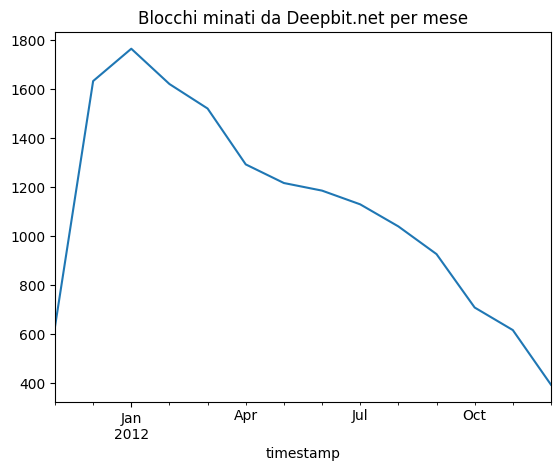

In [17]:
# Numero di transazioni per mese
monthly_counts = coinbase_deepb.resample('ME').size()
monthly_counts.plot(title='Blocchi minati da Deepbit.net per mese')

<Axes: title={'center': 'Blocchi minati da Deepbit.net per settimana'}, xlabel='timestamp'>

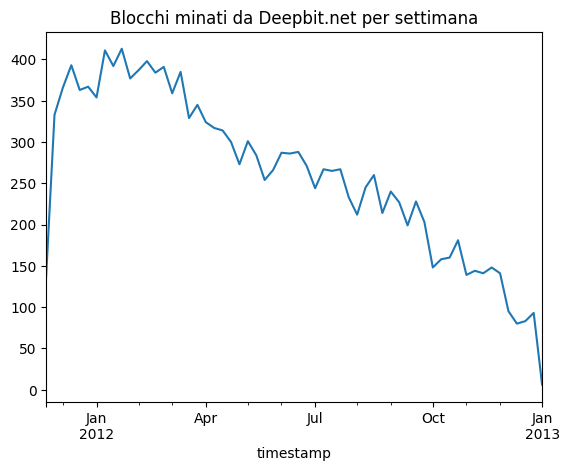

In [18]:
# Numero di transazioni per mese
weekly_counts = coinbase_deepb.resample('W').size()
weekly_counts.plot(title='Blocchi minati da Deepbit.net per settimana')

C:\Users\matte\AppData\Local\Temp\ipykernel_42472\524359246.py:2: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_counts = coinbase_deepb.resample('Y').size()


<Axes: title={'center': 'Blocchi minati da Deepbit.net per anno'}, xlabel='timestamp'>

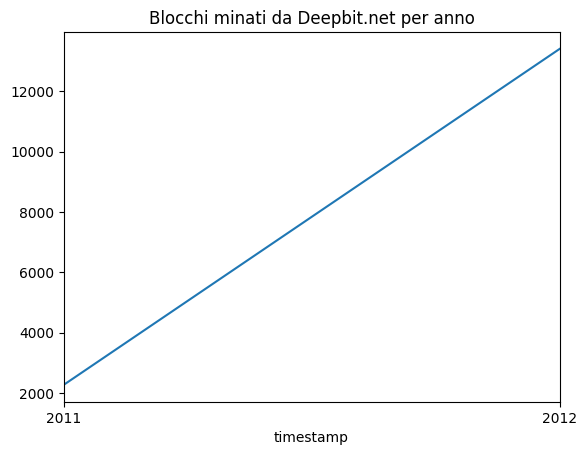

In [19]:
# Numero di transazioni per mese
yearly_counts = coinbase_deepb.resample('Y').size()
yearly_counts.plot(title='Blocchi minati da Deepbit.net per anno')

## 2)Distribuzione delle fee ai minatori

In [20]:
amounts = inputs_df.merge(outputs_df,left_on=["prev_tx_id","prev_tx_pos"], right_on=["tx_id","position"],suffixes=('_input', '_output'))
display(amounts)

,tx_id_input,prev_tx_id,prev_tx_pos,tx_id_output,position,addressId,amount,script_type
0,171,9,0,9,0,9,5000000000,1
1,183,171,1,171,1,9,4000000000,1
2,185,183,1,183,1,9,3000000000,1
3,187,185,1,185,1,9,2900000000,1
4,192,187,0,187,0,187,100000000,1
...,...,...,...,...,...,...,...,...
21378765,10572823,10572820,7,10572820,7,3526385,10000000,2
21378766,10572824,10572820,5,10572820,5,3525822,10000000,2
21378767,10572825,10572820,6,10572820,6,3517234,10000000,2
21378768,10572826,10572820,2,10572820,2,3524243,10000000,2


### Recupero gli amount di ogni transazione di input/output

In [21]:
input_amount = amounts.groupby('tx_id_input')["amount"].sum().rename('input_total')
output_amount = outputs_df.groupby('tx_id')['amount'].sum().rename('output_total')
display(input_amount,output_amount)

tx_id_input
171          5000000000
183          4000000000
185          3000000000
187          2900000000
192           100000000
               ...     
10572822       10000000
10572823       10000000
10572824       10000000
10572825       10000000
10572826    16009992200
Name: input_total, Length: 10358266, dtype: int64

tx_id
0            5000000000
1            5000000000
2            5000000000
3            5000000000
4            5000000000
               ...     
10572822        9900000
10572823        9900000
10572824        9900000
10572825        9900000
10572826    16009892200
Name: output_total, Length: 10572827, dtype: int64

In [22]:
fees = pd.concat([input_amount,output_amount],axis=1)
fees['fee'] = fees['input_total'] - fees['output_total']
fees = fees.reset_index().rename(columns={'index':'tx_id'})
fees = fees.merge(
    transactions[['tx_id', 'is_coinbase', 'block_height']],
    on='tx_id',
    how='left'
)
not_coinbase = fees["is_coinbase"] == 0
fees = fees[not_coinbase]
fee_per_block = fees.groupby('block_height')['fee'].sum().reset_index()
display(fee_per_block)

,block_height,fee
0,170,0.0
1,181,0.0
2,182,0.0
3,183,0.0
4,187,0.0
...,...,...
130647,214557,2825000.0
130648,214558,36100000.0
130649,214559,21430000.0
130650,214561,5524214.0


## 3)Calcolo degli UTXO(Unspent Transaction Output)

In [23]:

diff = outputs_df.merge(
    amounts[['tx_id_output', 'position']],
    left_on=['tx_id', 'position'],
    right_on=['tx_id_output', 'position'],
    how='left',
    indicator=True
)
# Filtra quelli non trovati nel merge (cioè non spesi)
unspent_df = diff[diff['_merge'] == 'left_only'].copy()


## Controllo dataframe(rimuovere)

In [24]:
display(len(unspent_df))
display(len(diff[diff["_merge"]!='left_only']))
display(len(unspent_df)+len(diff[diff['_merge']!='left_only']))
assert (len(diff) == len(unspent_df)+len(diff[diff['_merge']!='left_only']))
display(unspent_df)

3235029

21378770

24613799

,tx_id,position,addressId,amount,script_type,tx_id_output,_merge
0,0,0,0,5000000000,1,NaN,left_only
1,1,0,1,5000000000,1,NaN,left_only
2,2,0,2,5000000000,1,NaN,left_only
3,3,0,3,5000000000,1,NaN,left_only
4,4,0,4,5000000000,1,NaN,left_only
...,...,...,...,...,...,...,...
24613794,10572825,0,8707915,1,2,NaN,left_only
24613795,10572825,1,6137715,9899999,2,NaN,left_only
24613796,10572826,0,8707915,26651306,2,NaN,left_only
24613797,10572826,1,6137711,7991620447,2,NaN,left_only


### Ricavo i timestamp

In [25]:
UTXO_df = unspent_df.merge(transactions,how="left",on="tx_id")[["amount","timestamp"]]
UTXO_df["timestamp"] = pd.to_datetime(UTXO_df["timestamp"],unit="s")
UTXO_df = UTXO_df.set_index("timestamp")
display(UTXO_df)


,amount
timestamp,
2009-01-03 18:15:05,5000000000
2009-01-09 02:54:25,5000000000
2009-01-09 02:55:44,5000000000
2009-01-09 03:02:53,5000000000
2009-01-09 03:16:28,5000000000
...,...
2012-12-31 23:52:37,1
2012-12-31 23:52:37,9899999
2012-12-31 23:52:37,26651306


C:\Users\matte\AppData\Local\Temp\ipykernel_42472\3483965704.py:2: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  monthly_UTXO = UTXO_df.resample('Y').size()


<Axes: title={'center': 'UTXO per anni'}, xlabel='timestamp'>

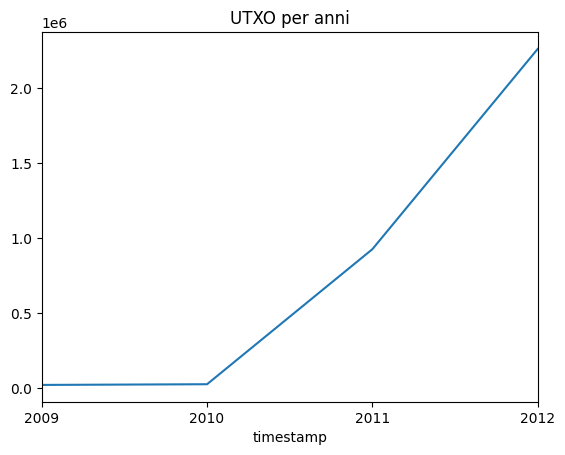

In [26]:
# Numero di transazioni per mese
monthly_UTXO = UTXO_df.resample('Y').size()
monthly_UTXO.plot(title='UTXO per anni')

## Costruzione Grafo Transazione tx_id = 1883820 

In [27]:
root_transaction = transactions[transactions["tx_id"] == 1883820];
root_output = outputs_df[outputs_df["tx_id"] == 1883820]
# display(pd.to_datetime(root_transaction["timestamp"],unit='s'))
display(root_output,root_transaction)

,tx_id,position,addressId,amount,script_type
4366098,1883820,0,2536929,10003400000,2


,timestamp,block_height,tx_id,is_coinbase,fee
1883822,1321688370,153932,1883820,0,0


In [28]:
deepbit_hased_addresses = mapping_df[mapping_df["hash"].isin(deepbit_transactions)]["addressId"].tolist()

display(deepbit_hased_addresses)


[2536929, 2537090]

## Definizione Funzione Ricorsiva per ricostruire la catena di transazioni 

In [29]:
def chain_transactions(chain_output,othersDeepbit,change_addresses_transactions,change_addresses=[]):
    output_tx_id = chain_output["tx_id"]
    output_position = chain_output["position"]

    #maschere per ottenere l'input
    tx_id_mask = inputs_df["prev_tx_id"]== output_tx_id
    tx_pos_mask = inputs_df["prev_tx_pos"]==output_position
    
    #cerco il prossimo input della catena
    next = inputs_df[tx_id_mask & tx_pos_mask ]
    next_tx_id = int(next.iloc[0]["tx_id"])
    
    #maschere per ottenere l'output
    outputs_tx_id_mask = outputs_df["tx_id"] == (next_tx_id)
    
    #cerco gli output
    related_outputs = outputs_df[ outputs_tx_id_mask ]
    
    deepbit_matches = [address for address in related_outputs["addressId"] if address in deepbit_hased_addresses]

    othersDeepbit.extend(address for address in related_outputs["addressId"] if address not in deepbit_hased_addresses)

    if len(deepbit_matches) != 1:return change_addresses
    #ricavo il prossimo output
    chained = related_outputs[related_outputs["addressId"] == deepbit_matches[0]].iloc[0]
    change_addresses.append(int(chained["tx_id"]))
    #memorizzo il tx_id per poter riutilizzare le transazioni
    change_addresses_transactions.append(
    {
        "tx_id":      int(chained["tx_id"]),
        "position":   int(chained["position"]),
        "addressId":  int(chained["addressId"]),
        "amount":     float(chained["amount"])
    }
    )
    return chain_transactions(chained,othersDeepbit,change_addresses_transactions,change_addresses)

### ricostruisco la catena

In [30]:
othersDeepbit = []
root_position = int(root_output.iloc[0]["position"])
root_tx_id = int(root_output.iloc[0]["tx_id"])
change_addresses_transactions = []
ctx = chain_transactions(root_output.iloc[0],othersDeepbit,change_addresses_transactions)


In [35]:
# print(len(othersDeepbit))
# print(len(ctx))
# # display(change_addresses_transactions)
# display(ctx)


## Rappresentazione della catena mediante grafo

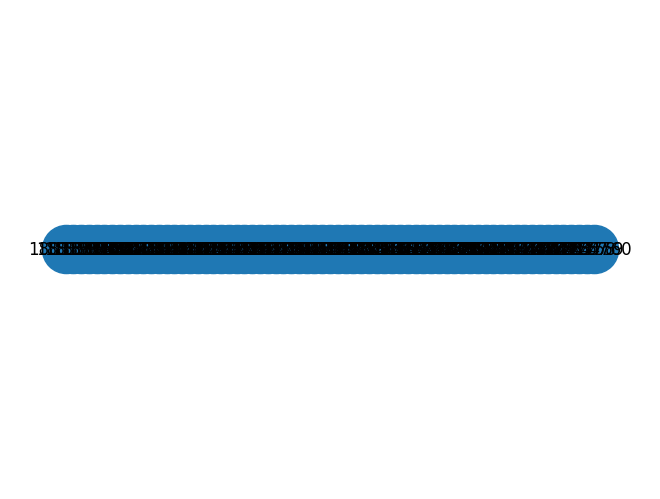

In [63]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()
chain_tx_ids = ctx

# aggiungo archi tra tx consecutive
for i in range(len(chain_tx_ids) - 1):
    t1 = chain_tx_ids[i]
    t2 = chain_tx_ids[i+1]
    G.add_edge(t1, t2,label = change_addresses_transactions[i]["amount"])

# pos = nx.spring_layout(G, k=0.8)

# nx.draw(G, pos, with_labels=True, node_size=1200, arrowsize=20)

# edge_labels = nx.get_edge_attributes(G, "amount")
# # nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

# plt.show()

# # pos = nx.kamada_kawai_layout(G)

# nx.draw(G, pos, with_labels=True, node_size=1200, arrowsize=20)

# plt.show()

# pos = nx.shell_layout(G)

# nx.draw(G, pos, with_labels=True, node_size=1200, arrowsize=20)

# plt.show()

# pos = nx.circular_layout(G)

# nx.draw(G, pos, with_labels=True, node_size=1200, arrowsize=20)

# plt.show()

# pos = nx.spectral_layout(G)

# nx.draw(G, pos, with_labels=True, node_size=1200, arrowsize=20)

# plt.show()

spacing = 1000000

n = len(chain_tx_ids)
x_positions = np.linspace(0, n * 5, n)  # 5 = spazio medio, regolabile

pos = {tx: (x, 0) for tx, x in zip(chain_tx_ids, x_positions)}
#custom:
# pos = {tx: (i * spacing, 0) for i, tx in enumerate(chain_tx_ids)}
nx.draw(G, pos, with_labels=True, node_size=1200, arrowsize=20)
plt.show()



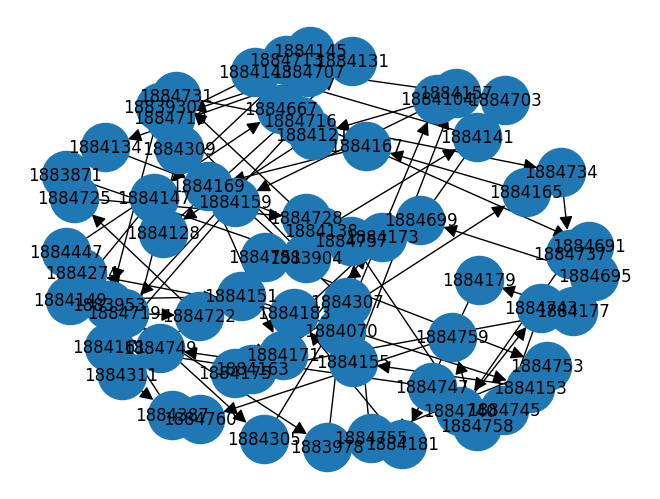

In [46]:
pos = nx.spring_layout(G, k=0.8)

nx.draw(G, pos, with_labels=True, node_size=1200, arrowsize=20)
plt.show()

## Calcolo differenze tra transazioni(Ricontrollare Tutto Sotto Questo)

In [33]:
#ricontrollare

diffs = []
for edge in G.edges:
    t1,t2 = [*edge]
    
    stamp1 = transactions[transactions["tx_id"] == t1].iloc[0]["timestamp"]
    stamp2 = transactions[transactions["tx_id"] == t2].iloc[0]["timestamp"]
    amt1 = outputs_df[outputs_df["tx_id"] == t1].iloc[0]["amount"]
    amt2 = outputs_df[outputs_df["tx_id"] == t2].iloc[0]["amount"]
    # print(f'timestamps: {stamp1}, {stamp2}\n amounts: {amt1},{amt2}')
    diffs.append(
        {
            "timestamp":stamp1-stamp2,
            "amount":amt1-amt2
        }
    )

diffs_df = pd.DataFrame(diffs)

## Grafico Descrittivo

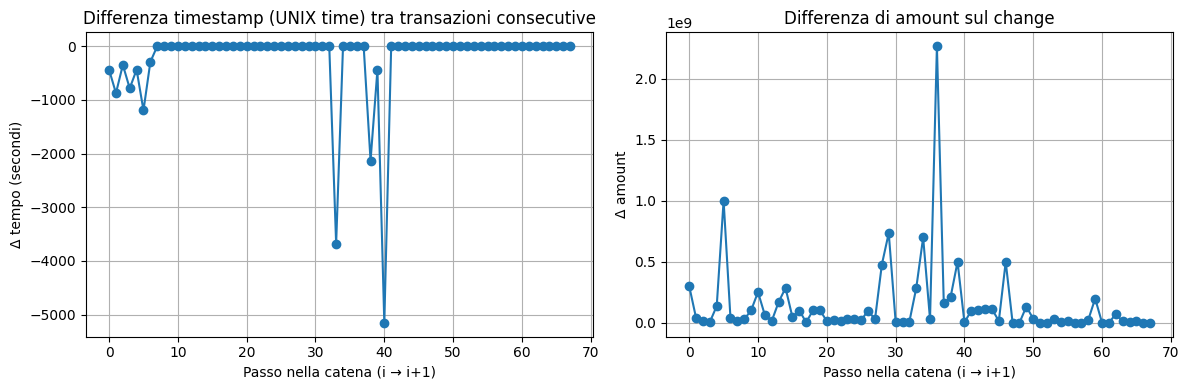

In [34]:
import matplotlib.pyplot as plt

x = range(len(diffs_df))

plt.figure(figsize=(12,4))

# Δ tempo
plt.subplot(1,2,1)
plt.plot(x, diffs_df["timestamp"], marker="o")
plt.xlabel("Passo nella catena (i → i+1)")
plt.ylabel("Δ tempo (secondi)")
plt.title("Differenza timestamp (UNIX time) tra transazioni consecutive")
plt.grid(True)

# Δ amount
plt.subplot(1,2,2)
plt.plot(x, diffs_df["amount"], marker="o")
plt.xlabel("Passo nella catena (i → i+1)")
plt.ylabel("Δ amount")
plt.title("Differenza di amount sul change")
plt.grid(True)

plt.tight_layout()
plt.show()


## Secondo passo di scraping da WalletExplorer